In [1]:
!pip install torch
!pip install transformers
!pip install perfplot
import ast


         .:::.     .::.       
        ....yy:    .yy.       
        :.  .yy.    y.        
             :y:   .:         
             .yy  .:          
              yy..:           
              :y:.            
              .y.             
             .:.              
        ....:.                
        :::.                  

• Project files and data should be stored in /project. This is shared among everyone
  in the project.
• Personal files and configuration should be stored in /home/faculty.
• Files outside /project and /home/faculty will be lost when this server is terminated.
• Create custom environments to setup your servers reproducibly.


         .:::.     .::.       
        ....yy:    .yy.       
        :.  .yy.    y.        
             :y:   .:         
             .yy  .:          
              yy..:           
              :y:.            
              .y.             
             .:.              
        ....:.                
        :::.       

In [2]:
import pandas as pd
import numpy as np

# Display the full output in this notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
df_full = pd.read_csv('/project/question-answers-processed/fin-ba-processed-combined.csv')
df_full.head()

,Unnamed: 0,question,answers,context_file,answer_start,answer_end,context
0,0,What is the fee for Business Analytics?,"UK - £19,400, and Overseas - £35,100",corpus/business-analytics/1.txt,63.0,99.0,Start date: September 2022 Duration: 12 months...
1,1,What is the fee for MSc of Business Analytics?,"UK - £19,400, and Overseas - £35,100",corpus/business-analytics/1.txt,63.0,99.0,Start date: September 2022 Duration: 12 months...
2,2,What's the masters fee for business analytics?,"UK - £19,400, and Overseas - £35,100",corpus/business-analytics/1.txt,63.0,99.0,Start date: September 2022 Duration: 12 months...
3,3,How much does it cost for international studen...,"UK - £19,400, and Overseas - £35,100",corpus/business-analytics/1.txt,63.0,99.0,Start date: September 2022 Duration: 12 months...
4,4,How much is it for overseas student to study B...,"UK - £19,400, and Overseas - £35,100",corpus/business-analytics/1.txt,63.0,99.0,Start date: September 2022 Duration: 12 months...


In [4]:
from sklearn.model_selection import train_test_split

df_train, df_dev = train_test_split(df_full, test_size=0.2, random_state=42)

# Split df_dev into a validation and test set
df_dev, df_test = df_dev[:205], df_dev[205:]

In [5]:
len(df_train)
len(df_dev)
len(df_test)

1633

205

204

In [6]:
from transformers import ElectraTokenizerFast
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, pipeline

model_electra = "deepset/electra-base-squad2"

model = AutoModelForQuestionAnswering.from_pretrained(model_electra)
tokenizer = AutoTokenizer.from_pretrained(model_electra)


In [7]:
from tqdm.auto import tqdm  # for showing progress bar

In [8]:
trainer = tokenizer(list(df_train["context"]), list(df_train["question"]),
                  truncation=True, padding='max_length',
                  max_length=512, return_tensors='pt')

In [9]:
len(trainer.input_ids[0])


512

In [10]:
df_train.shape

(1633, 7)

In [11]:
tokenizer.decode(trainer['input_ids'][0])


'[CLS] msc finance students are expected to have basic knowledge in financial mathematics and econometrics, and should be motivated to take their knowledge to the next level. to get to that next level, we expect a great deal from our students, so if you choose to study with us, you can expect to be working hard, challenging yourself as we challenge you, and regularly finding yourself out of your comfort zone. [SEP] are relevant work experiences required to be eligible for admission for the master program in finance? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

In [12]:
df_train = df_train.astype({"answer_start": int, "answer_end": int})


In [13]:
train_start_pos = df_train['answer_start'].tolist()
train_end_pos = df_train['answer_end'].tolist()

In [14]:
# Import the start_position & end_position to the dict
trainer.update({'start_positions': train_start_pos, 'end_positions': train_end_pos})

In [15]:
# Check the keys in the dict
trainer.keys()


dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'])

In [16]:
# Train the model using Pytorch
import torch

class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

# build datasets for both our training data
train_dataset = SquadDataset(trainer)

In [17]:
# Feed our train dataset
loader = torch.utils.data.DataLoader(train_dataset,
                                     batch_size=32,
                                     shuffle=True)

In [18]:
from transformers import AdamW

# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')
model.to(device)
model.train()
optim = torch.optim.AdamW(model.parameters(), lr=5e-5)

ElectraForQuestionAnswering(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768

ElectraForQuestionAnswering(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768

Output()

<ipython-input-19-b7e4bea6ffd3>:7: UserWarning: To copy construct from a tensor, it is 
recommended to use sourceTensor.clone().detach() or 
sourceTensor.clone().detach().requires_grad_(True), rather than 
tensor.new_tensor(sourceTensor).
  lambda a: a.new_tensor(a),

<ipython-input-19-b7e4bea6ffd3>:10: UserWarning: To copy construct from a tensor, it is 
recommended to use sourceTensor.clone().detach() or 
sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lambda a: torch.tensor(a),

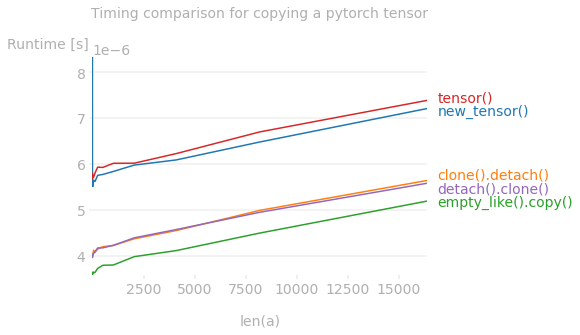

In [19]:
import torch
import perfplot

perfplot.show(
    setup=lambda n: torch.randn(n),
    kernels=[
        lambda a: a.new_tensor(a),
        lambda a: a.clone().detach(),
        lambda a: torch.empty_like(a).copy_(a),
        lambda a: torch.tensor(a),
        lambda a: a.detach().clone(),
    ],
    labels=["new_tensor()", "clone().detach()", "empty_like().copy()", "tensor()", "detach().clone()"],
    n_range=[2 ** k for k in range(15)],
    xlabel="len(a)",
    logx=False,
    logy=False,
    title='Timing comparison for copying a pytorch tensor',
)

In [20]:
for epoch in range(16):
    loop = tqdm(loader)
    
    
    for batch in loop:
        optim.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        #print('inputid', input_ids)
        #print('inputid', input_ids.shape) 
        #print('attnm', attention_mask)
        #print('startpos', start_positions)
        #print('startpos', end_positions)

        outputs = model(input_ids, attention_mask=attention_mask, 
                        start_positions=start_positions,
                        end_positions=end_positions)
        
        loss = outputs[0]
        loss.sum().backward()
        optim.step()

        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.sum().item())

  0%|          | 0/52 [00:00<?, ?it/s]

<ipython-input-16-ae3f548fe8f8>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

### Testing on the dev model


In [21]:
from transformers import pipeline
nlp = pipeline('question-answering', model=model, tokenizer=tokenizer)

In [22]:
df_dev['question'].values[0]


'Do I need basic finance knowledge for the Finance master?'

In [23]:
df_dev.reset_index(drop=True, inplace=True)


In [24]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

nlp('how are u', 'I am good today')

{'score': 0.0004534504550974816, 'start': 2, 'end': 4, 'answer': 'am'}

In [25]:
nlp(df_dev.loc[1]['question'], df_dev.loc[1]['context'])['score']


0.013196269050240517

In [26]:
df_dev


,Unnamed: 0,question,answers,context_file,answer_start,answer_end,context
0,1316,Do I need basic finance knowledge for the Fina...,MSc Finance students are expected to have basi...,corpus/finance/26.txt,0.0,167.0,MSc Finance students are expected to have basi...
1,1000,"For MSc Finance, what is the structure of the ...",All participants study four core modules in Te...,corpus/finance/3.txt,0.0,644.0,All participants study four core modules in Te...
2,1068,What is the requirement for GMAR or GRE exam f...,We do not require GMAT/GRE scores,corpus/finance/52.txt,378.0,411.0,Qualifications which are requested to support ...
3,1969,"For the master program in Finance, who should ...",the Programme Administrator via email at: mgmt...,corpus/finance/54.txt,76.0,140.0,For further information regarding the MSc Fina...
4,529,What information do I need to provide for my M...,You will need to include a degree transcript i...,corpus/business-analytics/105.txt,0.0,232.0,You will need to include a degree transcript i...
...,...,...,...,...,...,...,...
200,367,Is there a contact email for potential candita...,the Programme Administrator via: mgmt-ba@ucl.a...,corpus/business-analytics/73.txt,76.0,126.0,For further information regarding the Business...
201,757,Does my bachelor degree has to be highly numer...,we stress to our applicants that this programm...,corpus/finance/28.txt,84.0,227.0,While we do welcome students from a wide varie...
202,1985,What is the structure of the program for the m...,All participants study four core modules in Te...,corpus/finance/3.txt,0.0,644.0,All participants study four core modules in Te...
203,1582,"For the master program in Finance, what is the...","UK/EU/Overseas - £38,000",corpus/finance/1.txt,63.0,87.0,Start date: September 2022 Duration: 12 months...


In [27]:
result_df = pd.DataFrame(columns=['question', 'answer', 'model_answer', 'confidence_score', 'start_index', 'end_index'])

for i in range(df_dev.shape[0]):
    output = nlp(df_dev['question'].values[i], df_dev['context'].values[i])
    output_df = pd.DataFrame({'question': df_dev['question'].values[i], 'answer': df_dev['answers'].values[i],'model_answer': output['answer'], 'confidence_score': output['score'], 'start_index':output['start'], 'end_index':output['end']}, index=[i])
    
    result_df = pd.concat([result_df, output_df])

In [28]:
result_df.to_csv('dev-set-verification/electra-base-squad2.csv')

result_df

,question,answer,model_answer,confidence_score,start_index,end_index
0,Do I need basic finance knowledge for the Fina...,MSc Finance students are expected to have basi...,"financial mathematics and econometrics, and sh...",0.001850,61,138
1,"For MSc Finance, what is the structure of the ...",All participants study four core modules in Te...,", again reflecting a quantitative thrust. An e...",0.000028,175,249
2,What is the requirement for GMAR or GRE exam f...,We do not require GMAT/GRE scores,", such as a 2:1 Bachelor’",0.011539,60,85
3,"For the master program in Finance, who should ...",the Programme Administrator via email at: mgmt...,Programme Administrator,0.003614,80,103
4,What information do I need to provide for my M...,You will need to include a degree transcript i...,evidence of their English language ability,0.000200,163,205
...,...,...,...,...,...,...
200,Is there a contact email for potential candita...,the Programme Administrator via: mgmt-ba@ucl.a...,please see the UCL Postgraduate Admissions,0.009819,170,212
201,Does my bachelor degree has to be highly numer...,we stress to our applicants that this programm...,prepare,0.115535,442,449
202,What is the structure of the program for the m...,All participants study four core modules in Te...,", providing a robust quantitative underpinning",0.002609,52,98
203,"For the master program in Finance, what is the...","UK/EU/Overseas - £38,000",met,0.022988,395,398


In [29]:
result_df['comparison'] = np.where(result_df['answer'] == result_df['model_answer'] , 'True', 'False')

result_df

,question,answer,model_answer,confidence_score,start_index,end_index,comparison
0,Do I need basic finance knowledge for the Fina...,MSc Finance students are expected to have basi...,"financial mathematics and econometrics, and sh...",0.001850,61,138,False
1,"For MSc Finance, what is the structure of the ...",All participants study four core modules in Te...,", again reflecting a quantitative thrust. An e...",0.000028,175,249,False
2,What is the requirement for GMAR or GRE exam f...,We do not require GMAT/GRE scores,", such as a 2:1 Bachelor’",0.011539,60,85,False
3,"For the master program in Finance, who should ...",the Programme Administrator via email at: mgmt...,Programme Administrator,0.003614,80,103,False
4,What information do I need to provide for my M...,You will need to include a degree transcript i...,evidence of their English language ability,0.000200,163,205,False
...,...,...,...,...,...,...,...
200,Is there a contact email for potential candita...,the Programme Administrator via: mgmt-ba@ucl.a...,please see the UCL Postgraduate Admissions,0.009819,170,212,False
201,Does my bachelor degree has to be highly numer...,we stress to our applicants that this programm...,prepare,0.115535,442,449,False
202,What is the structure of the program for the m...,All participants study four core modules in Te...,", providing a robust quantitative underpinning",0.002609,52,98,False
203,"For the master program in Finance, what is the...","UK/EU/Overseas - £38,000",met,0.022988,395,398,False


In [30]:
result_df.comparison.value_counts()


False    202
True       3
Name: comparison, dtype: int64

In [31]:
import collections

# get tokens from text; just by splitting by spces
def get_simple_tokens(text):
    tokens = [token.strip() for token in text.split()]
    
    return tokens

# calculate f1 score for a single prediction-answer pair
def get_f1(pred, answer):
    pred_tokens = get_simple_tokens(pred)
    ans_tokens = get_simple_tokens(answer)
    
    common_tokens = collections.Counter(pred_tokens) & collections.Counter(ans_tokens)
    common_tokens_n = sum(common_tokens.values())
    
    if common_tokens_n == 0:
        return 0
    
    precision = 1.0 * common_tokens_n/len(pred_tokens)
    recall = 1.0 * common_tokens_n/len(ans_tokens)
    
    f1 = 2*((precision*recall)/(precision+recall))
    
    return f1

In [32]:
f1_scores = []
for i in range(result_df.shape[0]):
    f1_scores.append(get_f1(result_df['model_answer'].values[i], result_df['answer'].values[i]))
    
result_df['f1_score'] = f1_scores

In [33]:
result_df['f1_score'].mean()


0.2230391225525393

In [34]:
# Plot the training and validation losses
fig = plt.figure(figsize=(18, 8))
x = list(range(1, 1+len(train_losses)))

plt.plot(x, train_losses, 'b', linewidth=2)
plt.plot(x, valid_losses, 'r', linewidth=2)
plt.xlabel('Epoch #')
plt.ylabel('Binary Cross-Entropy Loss')
plt.legend(('Training Loss', 'Validation Loss'))
plt.show()

NameError: name 'plt' is not defined